# R kernel

In [1]:
suppressMessages({
library(ggplot2)
library(dplyr)
library(tidyr)
library(ggpubr)
library(cowplot)
library(rstatix)
library(reshape2)
library(ggnewscale)
library(RColorBrewer)
})

In [2]:
mytheme = function(){
theme_bw() +
theme(axis.text.x=element_text(size=6,color='black'),
    axis.text.y=element_text(size=6,color="black"),
    axis.title.y=element_text(size=6,color="black"),
    axis.title.x=element_text(size=6,color="black"),
    #axis.ticks.x=element_blank(),
    axis.ticks.length=unit(.02, "in"),
    axis.line = element_line(color = "black", linewidth = 0.25),
    axis.ticks = element_line(color = "black", linewidth = 0.25),
    strip.text.x = element_text(size = 6,margin = margin(0.1,0,0.1,0, "cm")),
    strip.text.y = element_text(size = 6,margin = margin(0,0.1,0,0.1, "cm")),
    strip.background=element_rect(linewidth=0.25),
    legend.text=element_text(size=6,color="black"),
    legend.title=element_text(size=6,color="black"),
    legend.key.width=unit(0.2,'cm'),
    legend.key.height=unit(0.2,'cm'),
    legend.box.margin=margin(0,0,0,2),
    legend.box.spacing = unit(0, "pt"),
    panel.spacing = unit(0.1, "cm"),
    plot.title = element_text(size=5),
    #panel.border = element_rect(size=0.25,color="black"),
    panel.grid = element_blank()
)
}

## Fig.S3D

In [3]:
cell_density = read.csv("../Figure1/Cell_density.csv",head=T, check.names = F)
cell_density$group = factor(cell_density$group, levels=c('HC','DLE','SLE'))
cell_density = cell_density[cell_density$Region == 'All',]

In [12]:
test_result = cell_density %>%
  as.data.frame() %>%
  setNames(make.names(names(.), TRUE)) %>%
  dunn_test(cell_density_mm2 ~ group)
test_result$p.format = sprintf("%.3f", test_result$p.adj)
test_result <- test_result %>% mutate(y.position = c(3500, 3500, 3500))

png 
  2

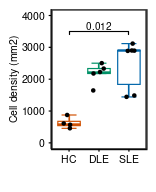

In [43]:
plot = ggplot(cell_density, aes(x=group,y=cell_density_mm2,color=group)) +
stat_boxplot( geom = "errorbar", width=0.5, linewidth=0.25) +
geom_boxplot(outlier.shape = NA,size=0.25) +  #outlier.shape = NA
geom_jitter(size=1,width=0.2,color='black',alpha=1,shape=19, stroke=NA) +
stat_pvalue_manual(test_result, label = "p.format", label.size=2, hide.ns=T, bracket.size=0.25, tip.length = 0.03) +
labs(x="",y='Cell density (mm2)') +
scale_y_continuous(limits = c(0,4000)) +
scale_color_manual(values=group_color) +
mytheme() + 
theme(legend.position = 'none')

options(repr.plot.width =1.3,repr.plot.height =1.6)
plot

pdf("../../figures/Cell_density_All.pdf", w=1.3, h=1.6)
plot 
dev.off()

## Fig.S3E

In [29]:
celltype_anno = read.csv("/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Cell2location_subtype/All_Cellbin_anno_gene200.csv",head=T,row.names=NULL)

In [30]:
celltype_color = c(
    "Keratinocytes" ="#CCFF00FF", 
    "Melanocytes" = "#FF4A46",
    "Schwann cells" = "#A30059",
    "Sweat gland cells" = "#006FA6",
    "Fibroblasts" = "#8FB0FF",
    "Endothelial cells" ="#B79762",
    "Smooth muscle cells" ="#6B7900",
    "T cells" = "#63FFAC",
    "NK cells" = "#9467BD" ,
    "B cells" = "#FF34FF",
    "Plasma cells" ="#FF7F0EFF",
    "Macrophage/DC" = "#008941",
    "Mast cells" = "#6A3A4C"
)

In [31]:
all_stats <- celltype_anno %>%
  group_by(sample, group, celltype) %>%
  summarise(count = n(), .groups = "drop_last") %>%
  group_by(sample, group) %>%
  mutate(percentage = count / sum(count) * 100) %>% 
  group_by(group, celltype) %>%
  summarise(
    mean_percentage = mean(percentage),
    sd_percentage = sd(percentage),
    sem_percentage = sd_percentage/sqrt(n()),
    n_samples = n()               
  )
all_stats$celltype = factor(all_stats$celltype, levels=names(celltype_color))
all_stats$group = factor(all_stats$group, levels=c("HC","DLE","SLE"))

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


png 
  2

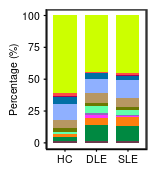

In [41]:
All_plot = ggplot(all_stats,aes(x=group,y=mean_percentage,fill=celltype)) +
    geom_bar(stat = "identity",width=0.7) +
    labs(x="",y="Percentage (%)",fill="Cell type") +
    scale_fill_manual(values=celltype_color) +
    mytheme() +
    theme(legend.position="none")
options(repr.plot.width= 1.3,repr.plot.height = 1.6)
All_plot

pdf("../../figures/Cellbin_celltype_rate_barplot_All.pdf",w=1.3,h=1.6)
All_plot
dev.off()

# Python kernel

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.backends.backend_pdf as pdf_backend
import warnings
warnings.filterwarnings('ignore')
import importlib

import utils_20250718
importlib.reload(utils_20250718)
from utils_20250718 import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
ST_adata = sc.read_h5ad('/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Cellbin_h5ad_raw/All_samples_Cellbin_filter_gene200_add_anno_dist.h5ad')
sc.pp.normalize_total(ST_adata, target_sum=10000)
sc.pp.log1p(ST_adata)

In [12]:
celltype_color = {
    "Keratinocytes" :"#CCFF00FF",
    "Melanocytes" : "#FF4A46",
    "Schwann cells" : "#A30059",
    "Sweat gland cells" : "#006FA6",
    "Fibroblasts" : "#8FB0FF",
    "Endothelial cells" :"#B79762",
    "Smooth muscle cells" :"#6B7900",
    "T cells" : "#63FFAC",
    "NK cells" : "#9467BD" ,
    "B cells" : "#FF34FF",
    "Plasma cells" :"#FF7F0EFF",
    "Macrophage/DC" : "#008941",
    "Mast cells" : "#6A3A4C"
}

In [18]:
SC_adata = sc.read_h5ad("/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/SC_data/SC_anno/scRNA_harmony_subtype_for_cell2loc_20240823.h5ad")
sc.pp.normalize_total(SC_adata, target_sum=10000)
sc.pp.log1p(SC_adata)

## Fig.S3A

In [3]:
adata = sc.read(f"/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Cell2location_celltype/SLE2_Cellbin_filter_gene100.celltype/SLE2_Cellbin_filter_gene100.denovo.h5ad")
adata.obsm['q05_cell_abundance_w_sf'].columns = adata.obsm['q05_cell_abundance_w_sf'].columns.str.replace('q05cell_abundance_w_sf_', '')
adata.obs[adata.obsm['q05_cell_abundance_w_sf'].columns] = adata.obsm['q05_cell_abundance_w_sf'].values
adata = adata[(adata.obs['n_genes_by_counts'] > 200) & (adata.obs['area'] > 100) & (adata.obs['pct_counts_MT'] <10 ) ]

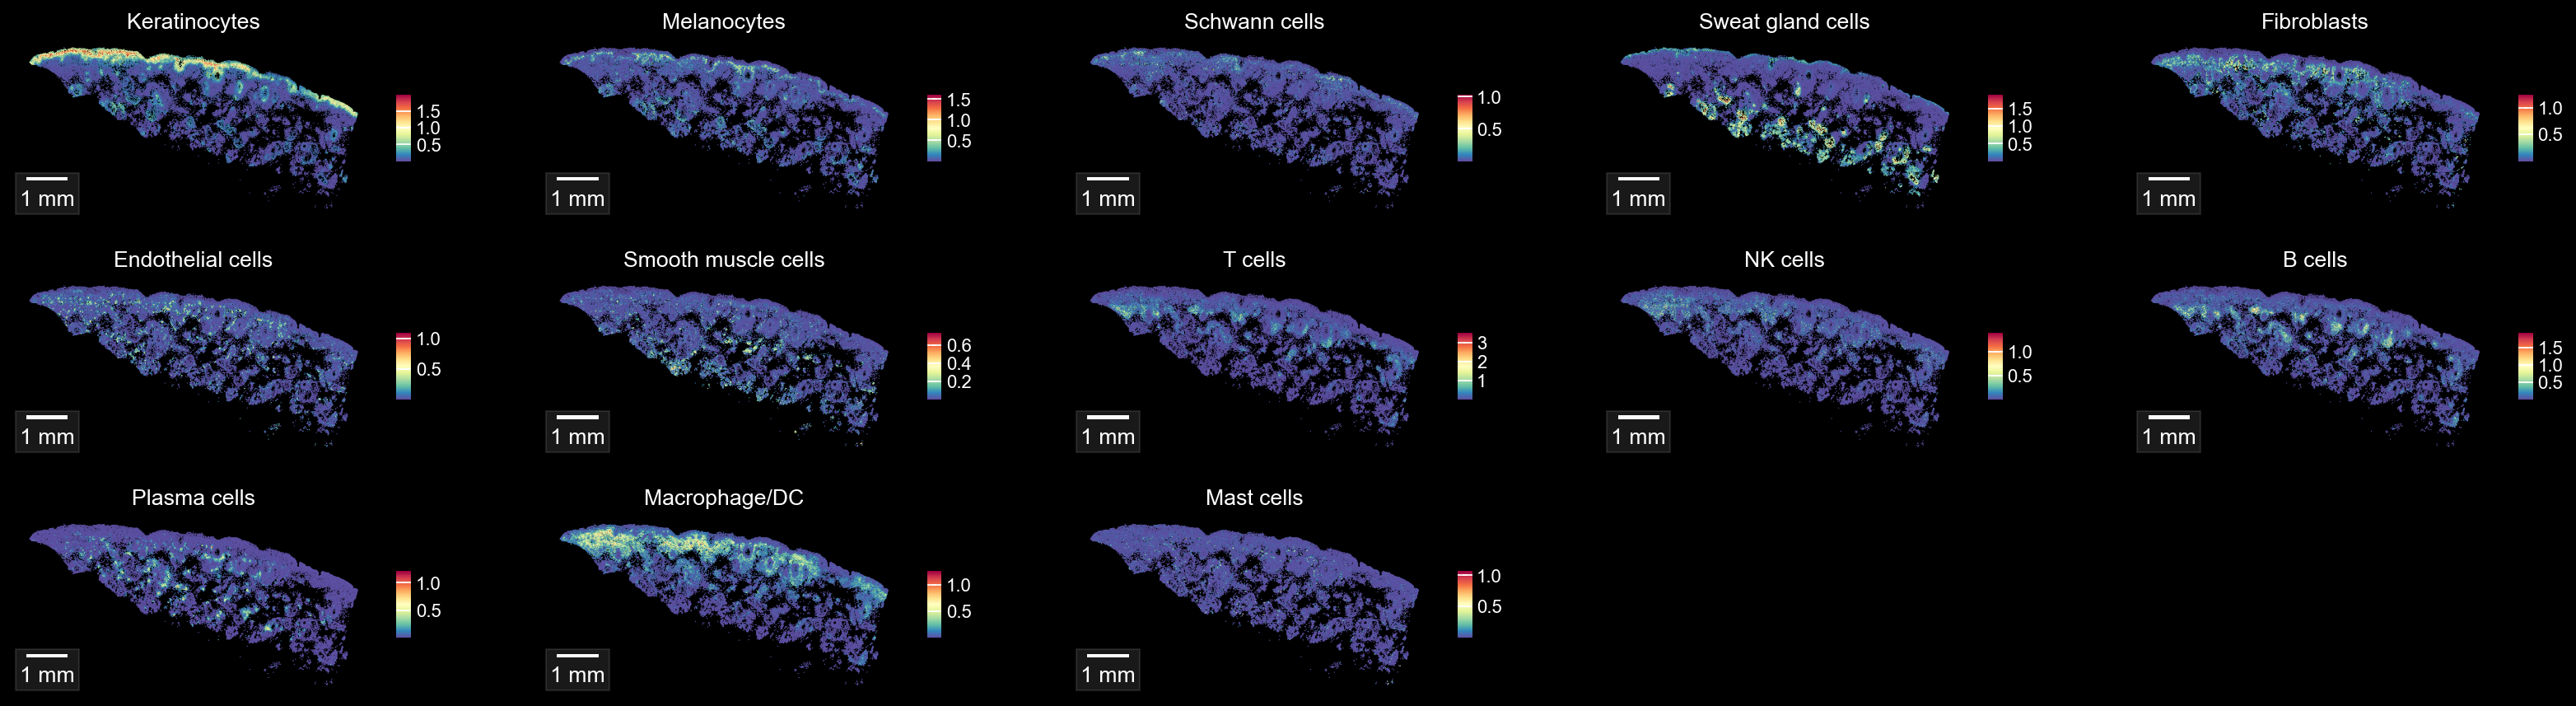

In [18]:
celltypes = celltype_color.keys()
with mpl.style.context('dark_background'):
    fig, axs = plt.subplots(nrows=3,ncols=5,figsize=(20, 6))
    axs_flat = axs.flatten()
    for i, celltype in enumerate(celltypes): 
        ax = axs_flat[i]   
        ax = featureplot(adata, celltype, reduction='spatial', dot_size=100, ncols=5, style="dark_background", ax=ax)
        ax.set_title(celltype, fontsize=12)
        draw_scalebar(ax=ax, color='white',location='lower left')
    for j in range(len(celltypes), len(axs_flat)):
        axs_flat[j].set_visible(False)
    #save_fig("../../figures/SLE2_cell2loc_celltype_score_spatial")

## Fig.S3B

In [4]:
samples = ["HC1",'HC3','HC4',"DLE1","DLE2","DLE3","DLE5","SLE1","SLE3","SLE4","SLE5","SLE6"]

[21:33:22] ❕  ssat is not registered, register now                                           ]8;id=202313;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=202455;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=89903;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=112229;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=754737;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=155300;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=610161;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=622960;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=116419;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=217371;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=231139;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=468473;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

[21:33:23] ❕  ssat is not registered, register now                                           ]8;id=298581;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=343903;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=667576;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=735766;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=76415;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=580299;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[21:33:24] 📃  add palette for `celltype` to adata.uns                                       ]8;id=934776;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=842833;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=192419;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=954183;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=538341;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=159047;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

[21:33:25] ❕  ssat is not registered, register now                                           ]8;id=387756;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=393133;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=535395;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=127753;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

[21:33:26] ❕  ssat is not registered, register now                                           ]8;id=227843;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=692195;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=503376;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=136903;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=547491;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=918643;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=864320;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=906888;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

[21:33:27] ❕  ssat is not registered, register now                                           ]8;id=818704;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=909256;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=847297;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=651286;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

[21:33:28] ❕  ssat is not registered, register now                                           ]8;id=624552;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=271922;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=409356;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=47806;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

[21:33:29] ❕  ssat is not registered, register now                                           ]8;id=272149;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=95094;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

           📃  add palette for `celltype` to adata.uns                                       ]8;id=74806;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=743189;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#1526\1526]8;;\

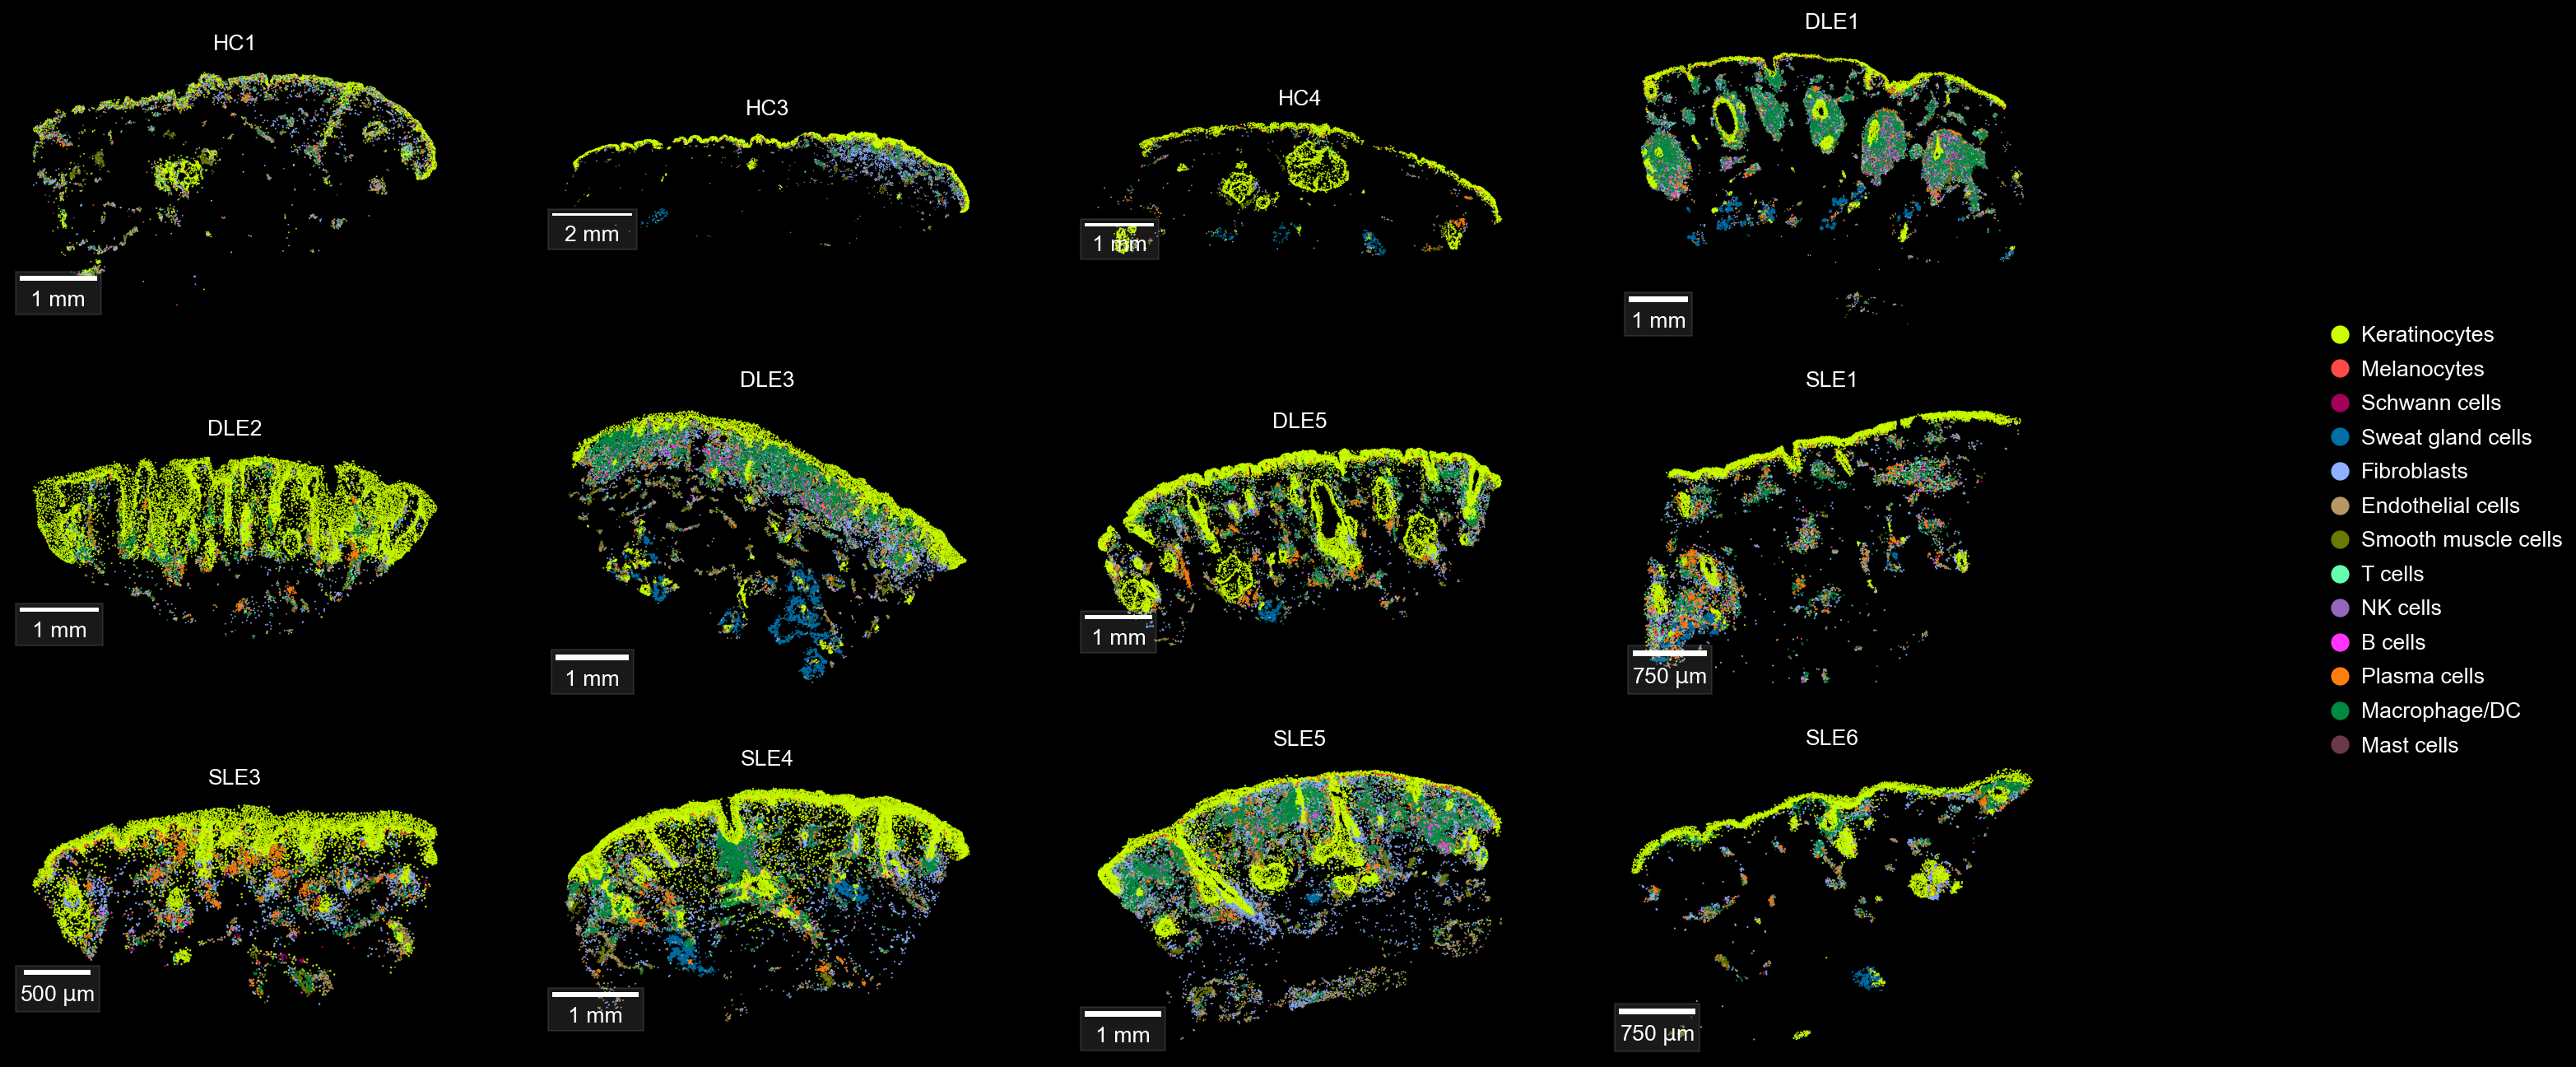

In [5]:
with mpl.style.context("dark_background"): 
    fig, axs =plt.subplots(figsize=(20, 10), ncols=4,nrows=3) 
    axs = axs.flatten()
    for i in range(0,len(samples)):
        sample_adata = ST_adata[ST_adata.obs['sample'] == samples[i]]
        sample_adata.obs['celltype'] = pd.Categorical(sample_adata.obs['celltype'], categories=celltype_color.keys())
              
        ax = dimplot(sample_adata,background=True,groupby="celltype", reduction="spatial", dot_size=20,legend=False,ax=axs[i], palette=celltype_color) #
        ax.set_title(f'{samples[i]}', fontsize=12)
        draw_scalebar(ax=ax, color='white',location='lower left')
    plot_legend(fig=fig)

## Fig.S3C

In [25]:
sc.pp.highly_variable_genes(SC_adata, flavor='cell_ranger', n_top_genes=5000, batch_key='orig.ident')
highly_variable_genes = SC_adata.var.loc[SC_adata.var['highly_variable'], :].index

In [26]:
common_genes = highly_variable_genes.intersection(ST_adata.var_names)
sc_adata = SC_adata[:, common_genes]
st_adata = ST_adata[:, common_genes]

In [27]:
SC_mean_expr = sc_adata.to_df().groupby(SC_adata.obs['celltype']).mean()
ST_mean_expr = st_adata.to_df().groupby(ST_adata.obs['celltype']).mean()

sc_types = SC_mean_expr.index
st_types = ST_mean_expr.index
correlation_matrix = np.zeros((len(sc_types), len(st_types)))

from scipy.stats import spearmanr
for i, sc_type in enumerate(sc_types):
    for j, st_type in enumerate(st_types):
        correlation_matrix[i, j] = spearmanr(SC_mean_expr.loc[sc_type], ST_mean_expr.loc[st_type])[0]

correlation_df = pd.DataFrame(correlation_matrix, index=sc_types, columns=st_types)
correlation_df = correlation_df.reindex(index=celltype_color.keys(), columns=celltype_color.keys())

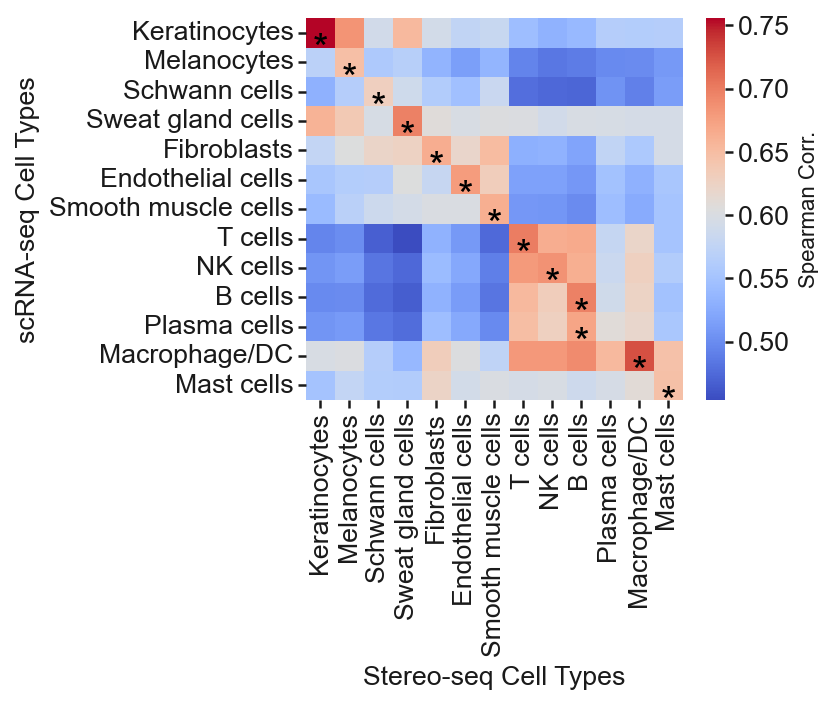

In [31]:
annot_matrix = np.empty_like(correlation_df, dtype=object)
for i in range(correlation_df.shape[0]):
    max_index = correlation_df.iloc[i].idxmax()
    for j in range(correlation_df.shape[1]):
        if correlation_df.columns[j] == max_index:
            annot_matrix[i, j] = '*' 
        else:
            annot_matrix[i, j] = ""

plt.figure(figsize=(3.8, 3.1))
ax = sns.heatmap(correlation_df, 
                 annot=annot_matrix, 
                 fmt='', 
                 cmap='coolwarm', 
                 #vmin=0, vmax=0.7,
                 cbar_kws={'label': 'Spearman Corr.'}, 
                 annot_kws={'fontsize': 18, 'color': 'black', 'va': 'top'}
                )

ax.set_xlabel('Stereo-seq Cell Types', fontsize=12)
ax.set_ylabel('scRNA-seq Cell Types', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12)

colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label('Spearman Corr.', fontsize=10)

#plt.savefig('figures/ST_SC_celltype_correlation.pdf')